# Spectra

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from dask.diagnostics import ProgressBar
import warnings
warnings.filterwarnings("ignore")

In [2]:
from yamlparser import YAMLParser, read_parameterized_runs, read_unparameterized_runs

In [3]:
yp = YAMLParser()

In [4]:
# read parameterized runs
exps_param = yp.read('/glade/u/home/noraloose/GL90paper/config_param.yaml')
%time exps_param = read_parameterized_runs(exps_param)

nw2_0.5deg_N15_KHTH800
nw2_0.5deg_N15_KHGL800_hbbl5
nw2_0.5deg_N15_KHTH800_vary
nw2_0.5deg_N15_KHGL800_vary_hbbl5
nw2_0.5deg_N15_EBT_KHTH800
nw2_0.5deg_N15_EBT_KHGL800_hbbl5
nw2_0.25deg_N15_KHTH300
nw2_0.25deg_N15_KHGL300_hbbl1
nw2_0.25deg_N15_KHGL300_hbbl5
nw2_0.25deg_N15_KHGL300_hbbl20
nw2_0.25deg_N15_KHGL300
nw2_0.25deg_N15_KHTH800
nw2_0.25deg_N15_KHGL800_hbbl5
nw2_0.25deg_N15_KHTH300_vary
nw2_0.25deg_N15_KHGL300_vary_hbbl5
nw2_0.25deg_N15_EBT_KHTH300
nw2_0.25deg_N15_EBT_KHGL300_hbbl5
nw2_0.125deg_N15_KHTH100
nw2_0.125deg_N15_KHGL100_hbbl5
nw2_0.125deg_N15_KHTH800
nw2_0.125deg_N15_KHGL800_hbbl5
nw2_0.125deg_N15_KHTH100_vary
nw2_0.125deg_N15_KHGL100_vary_hbbl5
nw2_0.125deg_N15_EBT_KHTH100
nw2_0.125deg_N15_EBT_KHGL100_hbbl5
CPU times: user 10.4 s, sys: 1.42 s, total: 11.9 s
Wall time: 1min 20s


In [5]:
# read unparameterized runs
exps_unparam = yp.read('/glade/u/home/noraloose/GL90paper/config_unparam.yaml')
%time exps_unparam = read_unparameterized_runs(exps_unparam)

CPU times: user 1.26 s, sys: 774 ms, total: 2.04 s
Wall time: 11.7 s


## Compute spectra 

In [6]:
import xrft

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 12}
pylab.rcParams.update(params)

In [8]:
def plot_spectra(exps, abc_list, colorlist=['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], component='v', title=''):
    # compute zonal spectra at the following 3 latitudes
    lat_list = [40, 15, -50]  
    lat_range_list = [slice(35, 45), slice(10, 20), slice(-55, -45)]
    window_list = ['hann', 'hann', None]  # we don't need tapering at 50S because here domain is periodic
    lat_lb_list= [r'35-45$^\circ$N', r'10-20$^\circ$N', r'45-55$^\circ$S']

    fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))

    for lat_range, lat, lat_lb, abc, window, ax in zip(lat_range_list, lat_list, lat_lb_list, abc_list, window_list, axs):

        for exp, color in zip(exps, colorlist):
            print(exp['label'])
            ds = exp['ds']
            #print(len(ds.time))
            #print(ds.time[0].values)

            st = exp['st']
            grid = exp['grid']
            
            # surface velocities
            u = grid.interp(ds.SSU, axis='X')
            v = grid.interp(ds.SSV, axis='Y')
            xi = st['dxT'].cumsum(dim='xh') - st['dxT'].isel(xh=0) # subtract first dx so that we start at x = 0m
            xline = xi.sel(yh=lat, method='nearest').drop('yh')

            uline = u.sel(yh=lat_range).fillna(0.)
            uline = uline.assign_coords(xh=xline) 

            vline = v.sel(yh=lat_range).fillna(0.)
            vline = vline.assign_coords(xh=xline) 

            uline = uline - uline.mean('time')
            vline = vline - vline.mean('time')
            
            uiso2 = xrft.power_spectrum(uline, dim=['xh'], scaling="density", window=window, detrend='linear').compute()
            viso2 = xrft.power_spectrum(vline, dim=['xh'], scaling="density", window=window, detrend='linear').compute()
            wavenumber = (uiso2.freq_xh * 1000 * 2 * np.pi)  # convert cycles per m to wavenumber in 1/km

            
            with ProgressBar():
                if component == 'v':
                    ekeiso = .5*(viso2)
                else:
                    ekeiso = .5*(uiso2 + viso2)
                   
                if 'freq_xh' in ekeiso:
                    ekeiso = ekeiso.isel(freq_xh=slice(int(len(ekeiso.freq_xh) /2.), None)).compute() # just one half of the symmetric spectrum

            ekeiso_mean = ekeiso.mean(dim=['time', 'yh'])

            ax.plot(wavenumber, ekeiso_mean, linewidth=3, label=exp['label'], color=color)

        # Rossby deformation scale
        # av.Rd1 is the Rossby "radius", where circumference / radius = 2 pi. As a result, we have the following analogies:
        # circumference <=> wavelength, radius <=> 2*pi/wavelength= 1/wavenumber; thus wavenumber = 1/Rd
        Ld_wavenumber = 1000 / (ds.Rd1.sel(yh=lat, method='nearest').mean(dim=['time','xh'])).compute()
        ax.plot([Ld_wavenumber, Ld_wavenumber], [1e-7,1e5], color='k', linestyle='dotted', linewidth=3, label='$k_D$')
 
        ax.set_title('%s %s' %(abc, lat_lb), fontsize=18)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([1e-7, 1e5])
        ax.set_xlim([1e-3, 2e0])
        ax.set_xlabel('')
        ax.grid()
        ax.tick_params(labelsize=18);
        ax.set_ylabel(r'[m$^3$ s$^{-2}$]',fontsize=16)
        ax.set_xlabel(r'Wavenumber k [1/km]',fontsize=16)

    for ax in [axs[1], axs[2]]:
        ax.set(yticklabels=[])
        ax.set_ylabel('')
    axs[1].legend(bbox_to_anchor=(0.5, -0.27), loc="upper center", ncol=4, fontsize=16)
    plt.suptitle(title, y=0.95)
    return fig

### 1/2 degree main text

1/2$^\circ$ GM 800
1/2$^\circ$ GL 800
1/32$^\circ$ no param
1/2$^\circ$ GM 800
1/2$^\circ$ GL 800
1/32$^\circ$ no param
1/2$^\circ$ GM 800
1/2$^\circ$ GL 800
1/32$^\circ$ no param


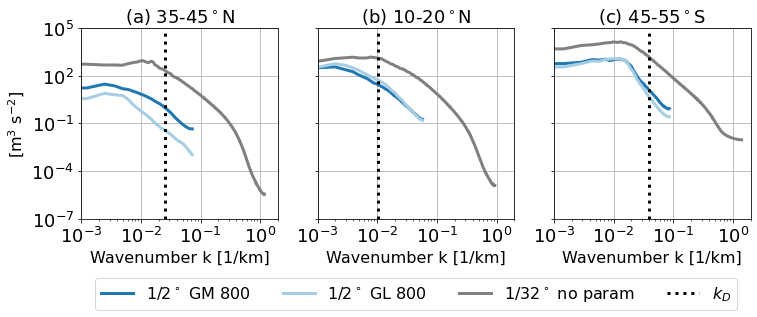

In [9]:
v = exps_param['nw2_0.5deg_N15_KHGL800_hbbl5']
v['label'] = r'1/2$^\circ$ GL 800'
v = exps_param['nw2_0.5deg_N15_KHTH800']
v['label'] = r'1/2$^\circ$ GM 800'


exp_list = [
    exps_param['nw2_0.5deg_N15_KHTH800'],
    exps_param['nw2_0.5deg_N15_KHGL800_hbbl5'],
    exps_unparam['nw2_0.03125deg_N15_baseline_hmix20']
]

colorlist = ['#1f78b4', '#a6cee3', 'gray']
abc_list = ['(a)', '(b)', '(c)']

fig = plot_spectra(exp_list, abc_list, colorlist, component='uv')
figname = '/glade/u/home/noraloose/GL90paper/figures/spectra_0.5degree.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

### 1/2 degree appendix

1/2$^\circ$ GM 800 $\cdot\, \phi(z)$
1/2$^\circ$ GL 800 $\cdot\, \phi(z)$
1/2$^\circ$ GM 800 $\cdot\, \psi(y)$
1/2$^\circ$ GL 800 $\cdot\, \psi(y)$
1/32$^\circ$ no param
1/2$^\circ$ GM 800 $\cdot\, \phi(z)$
1/2$^\circ$ GL 800 $\cdot\, \phi(z)$
1/2$^\circ$ GM 800 $\cdot\, \psi(y)$
1/2$^\circ$ GL 800 $\cdot\, \psi(y)$
1/32$^\circ$ no param
1/2$^\circ$ GM 800 $\cdot\, \phi(z)$
1/2$^\circ$ GL 800 $\cdot\, \phi(z)$
1/2$^\circ$ GM 800 $\cdot\, \psi(y)$
1/2$^\circ$ GL 800 $\cdot\, \psi(y)$
1/32$^\circ$ no param


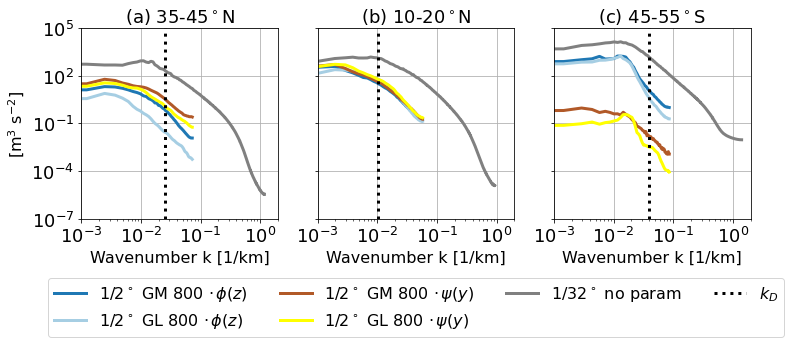

In [10]:
v = exps_param['nw2_0.5deg_N15_KHGL800_vary_hbbl5']
v['label'] = r'1/2$^\circ$ GL 800 $\cdot\, \psi(y)$'
v = exps_param['nw2_0.5deg_N15_KHTH800_vary']
v['label'] = r'1/2$^\circ$ GM 800 $\cdot\, \psi(y)$'
v = exps_param['nw2_0.5deg_N15_EBT_KHGL800_hbbl5']
v['label'] = r'1/2$^\circ$ GL 800 $\cdot\, \phi(z)$'
v = exps_param['nw2_0.5deg_N15_EBT_KHTH800']
v['label'] = r'1/2$^\circ$ GM 800 $\cdot\, \phi(z)$'

exp_list = [
    exps_param['nw2_0.5deg_N15_EBT_KHTH800'],
    exps_param['nw2_0.5deg_N15_EBT_KHGL800_hbbl5'],
    exps_param['nw2_0.5deg_N15_KHTH800_vary'],
    exps_param['nw2_0.5deg_N15_KHGL800_vary_hbbl5'],
    exps_unparam['nw2_0.03125deg_N15_baseline_hmix20']
]

colorlist = ['#1f78b4', '#a6cee3', '#b15928', 'yellow','gray']

abc_list = ['(a)', '(b)', '(c)']

fig = plot_spectra(exp_list, abc_list, colorlist, component='uv')
figname = '/glade/u/home/noraloose/GL90paper/figures/spectra_0.5degree_appendix.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

### 1/4 degree main text

1/4$^\circ$ GM 300
1/4$^\circ$ GL 300
1/4$^\circ$ GM 800
1/4$^\circ$ GL 800
1/4$^\circ$ no param
1/32$^\circ$ no param
1/4$^\circ$ GM 300
1/4$^\circ$ GL 300
1/4$^\circ$ GM 800
1/4$^\circ$ GL 800
1/4$^\circ$ no param
1/32$^\circ$ no param
1/4$^\circ$ GM 300
1/4$^\circ$ GL 300
1/4$^\circ$ GM 800
1/4$^\circ$ GL 800
1/4$^\circ$ no param
1/32$^\circ$ no param


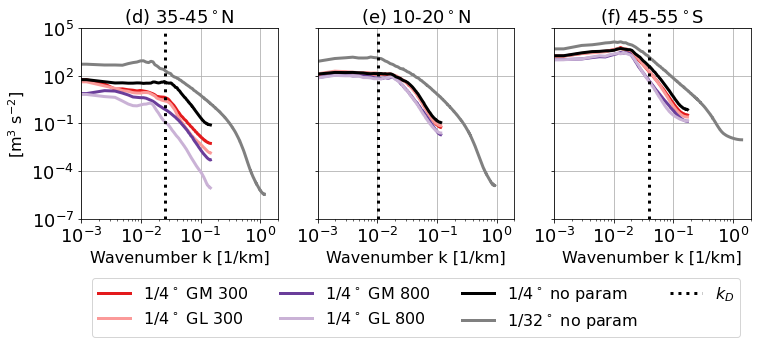

In [11]:
v = exps_param['nw2_0.25deg_N15_KHGL300_hbbl5']
v['label'] = r'1/4$^\circ$ GL 300'
v = exps_param['nw2_0.25deg_N15_KHGL800_hbbl5']
v['label'] = r'1/4$^\circ$ GL 800'

exp_list = [
    exps_param['nw2_0.25deg_N15_KHTH300'],
    exps_param['nw2_0.25deg_N15_KHGL300_hbbl5'],
    exps_param['nw2_0.25deg_N15_KHTH800'],
    exps_param['nw2_0.25deg_N15_KHGL800_hbbl5'],
    exps_unparam['nw2_0.25deg_N15_baseline_hmix20'],
    exps_unparam['nw2_0.03125deg_N15_baseline_hmix20']
]
    
colorlist = ['#e31a1c', '#fb9a99', '#6a3d9a','#cab2d6', 'k', 'gray']
abc_list = ['(d)', '(e)', '(f)']

fig = plot_spectra(exp_list, abc_list, colorlist, component='uv')
figname = '/glade/u/home/noraloose/GL90paper/figures/spectra_0.25degree.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

### 1/4 degree appendix

1/4$^\circ$ GM 300 $\cdot\, \phi(z)$
1/4$^\circ$ GL 300 $\cdot\, \phi(z)$
1/4$^\circ$ GM 300 $\cdot\, \psi(y)$
1/4$^\circ$ GL 300 $\cdot\, \psi(y)$
1/4$^\circ$ no param
1/32$^\circ$ no param
1/4$^\circ$ GM 300 $\cdot\, \phi(z)$
1/4$^\circ$ GL 300 $\cdot\, \phi(z)$
1/4$^\circ$ GM 300 $\cdot\, \psi(y)$
1/4$^\circ$ GL 300 $\cdot\, \psi(y)$
1/4$^\circ$ no param
1/32$^\circ$ no param
1/4$^\circ$ GM 300 $\cdot\, \phi(z)$
1/4$^\circ$ GL 300 $\cdot\, \phi(z)$
1/4$^\circ$ GM 300 $\cdot\, \psi(y)$
1/4$^\circ$ GL 300 $\cdot\, \psi(y)$
1/4$^\circ$ no param
1/32$^\circ$ no param


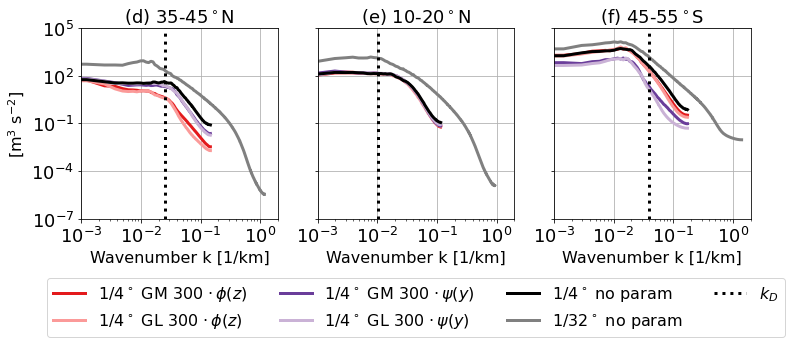

In [12]:
v = exps_param['nw2_0.25deg_N15_EBT_KHGL300_hbbl5']
v['label'] = r'1/4$^\circ$ GL 300 $\cdot\, \phi(z)$'
v = exps_param['nw2_0.25deg_N15_EBT_KHTH300']
v['label'] = r'1/4$^\circ$ GM 300 $\cdot\, \phi(z)$'
v = exps_param['nw2_0.25deg_N15_KHGL300_vary_hbbl5']
v['label'] = r'1/4$^\circ$ GL 300 $\cdot\, \psi(y)$'
v = exps_param['nw2_0.25deg_N15_KHTH300_vary']
v['label'] = r'1/4$^\circ$ GM 300 $\cdot\, \psi(y)$'

exp_list = [
    exps_param['nw2_0.25deg_N15_EBT_KHTH300'],
    exps_param['nw2_0.25deg_N15_EBT_KHGL300_hbbl5'],
    exps_param['nw2_0.25deg_N15_KHTH300_vary'],
    exps_param['nw2_0.25deg_N15_KHGL300_vary_hbbl5'],
    exps_unparam['nw2_0.25deg_N15_baseline_hmix20'],
    exps_unparam['nw2_0.03125deg_N15_baseline_hmix20']
]
    
colorlist = ['#e31a1c', '#fb9a99', '#6a3d9a','#cab2d6', 'k', 'gray']
abc_list = ['(d)', '(e)', '(f)']

fig = plot_spectra(exp_list, abc_list, colorlist, component='uv')
figname = '/glade/u/home/noraloose/GL90paper/figures/spectra_0.25degree_appendix.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

### 1/8 degree main text

1/8$^\circ$ GM 100
1/8$^\circ$ GL 100
1/8$^\circ$ GM 800
1/8$^\circ$ GL 800
1/8$^\circ$ no param
1/32$^\circ$ no param
1/8$^\circ$ GM 100
1/8$^\circ$ GL 100
1/8$^\circ$ GM 800
1/8$^\circ$ GL 800
1/8$^\circ$ no param
1/32$^\circ$ no param
1/8$^\circ$ GM 100
1/8$^\circ$ GL 100
1/8$^\circ$ GM 800
1/8$^\circ$ GL 800
1/8$^\circ$ no param
1/32$^\circ$ no param


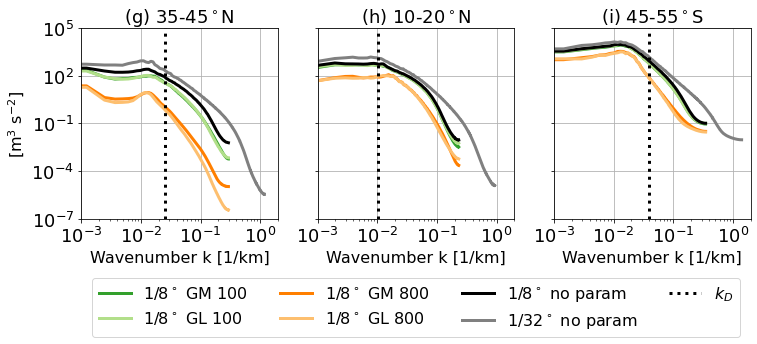

In [13]:
v = exps_param['nw2_0.125deg_N15_KHGL100_hbbl5']
v['label'] = r'1/8$^\circ$ GL 100'
v = exps_param['nw2_0.125deg_N15_KHGL800_hbbl5']
v['label'] = r'1/8$^\circ$ GL 800'

colorlist = ['#1f78b4', '#e31a1c','#addd8e', '#31a354']

exp_list = [
    exps_param['nw2_0.125deg_N15_KHTH100'],
    exps_param['nw2_0.125deg_N15_KHGL100_hbbl5'],
    exps_param['nw2_0.125deg_N15_KHTH800'],
    exps_param['nw2_0.125deg_N15_KHGL800_hbbl5'],
    exps_unparam['nw2_0.125deg_N15_baseline_hmix20'],
    exps_unparam['nw2_0.03125deg_N15_baseline_hmix20']
]

colorlist = ['#33a02c', '#b2df8a', '#ff7f00',  '#fdbf6f', 'k', 'gray']

abc_list = ['(g)', '(h)', '(i)']

fig = plot_spectra(exp_list, abc_list, colorlist, component='uv')
figname = '/glade/u/home/noraloose/GL90paper/figures/spectra_0.125degree.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

### 1/8 degree appendix

1/8$^\circ$ GM 100 $\cdot\, \phi(z)$
1/8$^\circ$ GL 100 $\cdot\, \phi(z)$
1/8$^\circ$ GM 100 $\cdot\, \psi(y)$
1/8$^\circ$ GL 100 $\cdot\, \psi(y)$
1/8$^\circ$ no param
1/32$^\circ$ no param
1/8$^\circ$ GM 100 $\cdot\, \phi(z)$
1/8$^\circ$ GL 100 $\cdot\, \phi(z)$
1/8$^\circ$ GM 100 $\cdot\, \psi(y)$
1/8$^\circ$ GL 100 $\cdot\, \psi(y)$
1/8$^\circ$ no param
1/32$^\circ$ no param
1/8$^\circ$ GM 100 $\cdot\, \phi(z)$
1/8$^\circ$ GL 100 $\cdot\, \phi(z)$
1/8$^\circ$ GM 100 $\cdot\, \psi(y)$
1/8$^\circ$ GL 100 $\cdot\, \psi(y)$
1/8$^\circ$ no param
1/32$^\circ$ no param


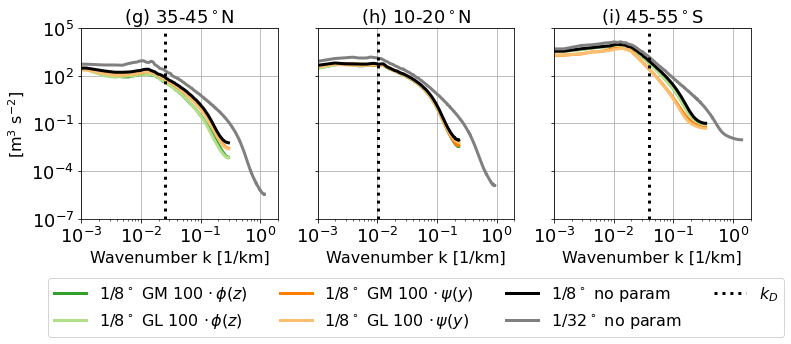

In [14]:
v = exps_param['nw2_0.125deg_N15_EBT_KHGL100_hbbl5']
v['label'] = r'1/8$^\circ$ GL 100 $\cdot\, \phi(z)$'
v = exps_param['nw2_0.125deg_N15_KHGL100_vary_hbbl5']
v['label'] = r'1/8$^\circ$ GL 100 $\cdot\, \psi(y)$'
v = exps_param['nw2_0.125deg_N15_EBT_KHTH100']
v['label'] = r'1/8$^\circ$ GM 100 $\cdot\, \phi(z)$'
v = exps_param['nw2_0.125deg_N15_KHTH100_vary']
v['label'] = r'1/8$^\circ$ GM 100 $\cdot\, \psi(y)$'


exp_list = [
    exps_param['nw2_0.125deg_N15_EBT_KHTH100'],
    exps_param['nw2_0.125deg_N15_EBT_KHGL100_hbbl5'],
    exps_param['nw2_0.125deg_N15_KHTH100_vary'],
    exps_param['nw2_0.125deg_N15_KHGL100_vary_hbbl5'],
    exps_unparam['nw2_0.125deg_N15_baseline_hmix20'],
    exps_unparam['nw2_0.03125deg_N15_baseline_hmix20']
]
    
colorlist = ['#33a02c', '#b2df8a', '#ff7f00',  '#fdbf6f', 'k', 'gray']

abc_list = ['(g)', '(h)', '(i)']

fig = plot_spectra(exp_list, abc_list, colorlist, component='uv')
figname = '/glade/u/home/noraloose/GL90paper/figures/spectra_0.125degree_appendix.png'
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)